In [1]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4./input_dim**2

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data



# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
images = np.array(sio.loadmat('WB_test64_GAN_sm2.mat')['WB_sm'],dtype='float32')
images[images==0]=-1
# images=images[0:10]

mb_size = 5
z_dim = 8
X_dim = images.shape[1]
width = 32
hight = 32
h_dim = width/4*hight/4
input_dim = 32
Rad = input_dim/2

conv1_features=64
conv2_features=32
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64
num_channels_3=32
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(width, hight), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

# X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, hight, num_channels_1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

# conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
#                                                stddev=0.1, dtype=tf.float32))
# conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
#     conv1 = tf.nn.conv2d(X, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
#     h1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
#     h1 = tf.reshape(h1,[mb_size,X_dim])
    
    h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) ======================================
def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, hight/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, hight/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, hight/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.tanh(h4)
    return prob


P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                               stddev=0.1, dtype=tf.float32))
deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                               stddev=0.1, dtype=tf.float32))
deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                               stddev=0.1, dtype=tf.float32))
deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)
combination_image=tf.reshape(X_samples[0],[1,height,width,1])
############# white noise ############
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.sigmoid(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=2, stride=2, padding="SAME")

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.sigmoid(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=2, stride=2, padding="SAME")

sl1 = style_loss(conv_out1[0,:,:,:], conv_out1_S[0,:,:,:])

# point correlation loss
# PC_ori=correlation_fun(X, input_dim=input_dim, Rad=Rad)
# PC_rec=correlation_fun(prob, input_dim=input_dim, Rad=Rad)
# PC_ran=correlation_fun(X_samples,input_dim=input_dim, Rad=Rad)

# PC_loss1=tf.abs(PC_ori-PC_rec)
# PC_loss2=tf.abs(PC_ori-PC_ran)

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss =tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))



# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)
tot_loss = tf.reduce_mean(recon_loss + kl_loss + sl1)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()

for it in range(20000):
    X_mb = images[(it*10)%100:(it*10)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E = sess.run([solver, vae_loss, recon_loss, kl_loss], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 500 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

#         fig = plot(samples)
#         plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 299.718811035
recon_E:273.048706055
kl_E:26.6701087952
()
Iter: 250
Loss: 233.138595581
recon_E:229.382736206
kl_E:3.75585842133
()
Iter: 500
Loss: 228.509078979
recon_E:222.712493896
kl_E:5.79657936096
()
Iter: 750
Loss: 227.981918335
recon_E:219.64906311
kl_E:8.33286190033
()
Iter: 1000
Loss: 214.437042236
recon_E:203.210525513
kl_E:11.2265224457
()
Iter: 1250
Loss: 210.22543335
recon_E:197.849609375
kl_E:12.3758268356
()
Iter: 1500
Loss: 202.829223633
recon_E:188.637451172
kl_E:14.1917734146
()
Iter: 1750
Loss: 200.813995361
recon_E:184.021438599
kl_E:16.7925643921
()
Iter: 2000
Loss: 195.709472656
recon_E:178.44644165
kl_E:17.2630271912
()
Iter: 2250
Loss: 192.397079468
recon_E:173.118728638
kl_E:19.2783508301
()
Iter: 2500
Loss: 185.084625244
recon_E:165.43939209
kl_E:19.645236969
()
Iter: 2750
Loss: 182.558868408
recon_E:161.039489746
kl_E:21.5193786621
()
Iter: 3000
Loss: 176.277313232
recon_E:154.749221802
kl_E:21.5280838013
()
Iter: 3250
Loss: 176.869812012
recon

/home/p2admin/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iter: 5250
Loss: 142.308456421
recon_E:115.266860962
kl_E:27.0415973663
()
Iter: 5500
Loss: 142.642379761
recon_E:115.05557251
kl_E:27.5868110657
()
Iter: 5750
Loss: 135.969772339
recon_E:107.68888855
kl_E:28.280878067
()
Iter: 6000
Loss: 143.938949585
recon_E:114.613647461
kl_E:29.325302124
()
Iter: 6250
Loss: 138.250091553
recon_E:109.687469482
kl_E:28.5626239777
()
Iter: 6500
Loss: 131.551391602
recon_E:102.728424072
kl_E:28.8229675293
()
Iter: 6750
Loss: 131.979949951
recon_E:103.383743286
kl_E:28.5962123871
()
Iter: 7000
Loss: 131.086578369
recon_E:102.900054932
kl_E:28.1865234375
()
Iter: 7250
Loss: 127.215545654
recon_E:98.6718902588
kl_E:28.5436553955
()
Iter: 7500
Loss: 131.998352051
recon_E:102.259742737
kl_E:29.7386131287
()
Iter: 7750
Loss: 122.583137512
recon_E:92.3994750977
kl_E:30.1836605072
()
Iter: 8000
Loss: 133.276992798
recon_E:104.458526611
kl_E:28.8184623718
()
Iter: 8250
Loss: 122.551780701
recon_E:94.008430481
kl_E:28.5433521271
()
Iter: 8500
Loss: 126.036880493

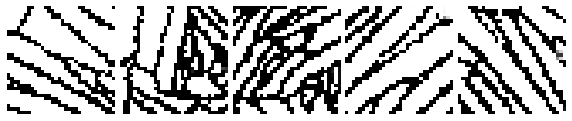

In [32]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

X_mb=images[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(sample_temp)

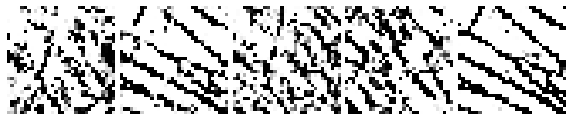

In [41]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

#     return fig
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
sample_sort=samples.reshape(-1)
# sample_sort.sort()
# samples[samples>=(np.sort(sample_sort))[300]]=1
# samples[samples<(np.sort(sample_sort))[300]]=-1
plot(samples)

In [27]:
def correlation_fun_test(xx,input_dim,Rad):
    sum_store=[]
    for ii in range(len(xx)):
        x = xx[ii]
        point_corr=0
#     if Rad <=50:
        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp1=(x[i,j]*x[i,np.mod(j+Rad,input_dim)])
                point_corr=point_corr_temp1+point_corr

        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp2=x[i,j]*x[np.mod(i+Rad,input_dim),j]
                point_corr=(point_corr_temp2+point_corr)
        sum_store.append((point_corr+2*input_dim**2)/4.)
#     print(point_corr)
    return sum_store

In [42]:
S2 = np.zeros([2*mb_size,17])
for i in range(2):
    samples=sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
    for j in range(17):
        S2[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=samples,input_dim=32,Rad=j)
#     plt.hist(samples.reshape(-1))

S2_ori = np.zeros([2*mb_size,17])
for i in range(2):
    for j in range(17):
        sample_ori=images[i*mb_size:(i+1)*mb_size].reshape(mb_size,32,32,1)
        S2_ori[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=sample_ori,input_dim=32,Rad=j)

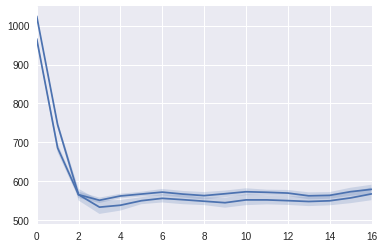

In [45]:
import seaborn as sns
%matplotlib inline
x = np.linspace(0, 16, 17)
sns.tsplot(data=S2)
sns.tsplot(data=S2_ori)

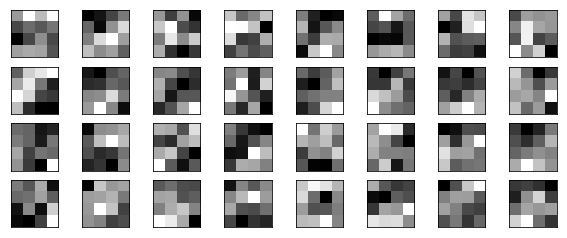

In [5]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 32  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(4, n/4, i + 1)
    plt.imshow(W3[:,:,:,i].reshape(4, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Using TensorFlow backend.


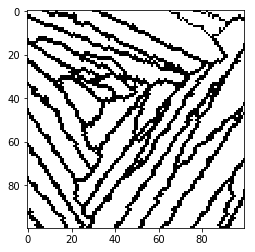

In [1]:
import scipy.io as sio
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
height=48
width =48
########### autoencoder
W1 = np.array(sio.loadmat('weights/W1_Ti.mat')['W'],dtype='float32')
W2 = np.array(sio.loadmat('weights/W2_Ti.mat')['W'],dtype='float32')
# W3 = np.array(sio.loadmat('weights_AE/W3_AE.mat')['weights_3'],dtype='float32')

bias1=np.array(sio.loadmat('weights/bias1_Ti.mat')['bias'],dtype='float32')
bias2=np.array(sio.loadmat('weights/bias2_Ti.mat')['bias'],dtype='float32')
# bias3=np.array(sio.loadmat('weights_AE/bias3_AE.mat')['biases_3'],dtype='float32')

########### RBM

# # # W1 = np.array(sio.loadmat('weights_RBM/W1_RBM.mat')['W1'],dtype='float32')
# W1 = np.array(sio.loadmat('W1_Ti.mat')['W1'],dtype='float32')
# W2 = np.array(sio.loadmat('W2_Ti.mat')['W2'],dtype='float32')
# W3 = np.array(sio.loadmat('W3_Ti.mat')['W3'],dtype='float32')

# # # bias1=np.array(sio.loadmat('weights_RBM/bias1_RBM.mat')['hbias_vec'],dtype='float32')
# bias1=np.array(sio.loadmat('bias1_Ti.mat')['bias1'],dtype='float32')
# bias2=np.array(sio.loadmat('bias2_Ti.mat')['bias2'],dtype='float32')
# bias3=np.array(sio.loadmat('bias3_Ti.mat')['bias3'],dtype='float32')

# W1 = np.array(sio.loadmat('W1_Ti.mat')['W1'],dtype='float32')

# bias1=np.array(sio.loadmat('weights_RBM/bias1_RBM.mat')['hbias_vec'],dtype='float32')
# bias1=np.array(sio.loadmat('bias1_Ti.mat')['bias1'],dtype='float32')

images = np.array(sio.loadmat('alloy_mat/WB_sm.mat')['WB_sm'],dtype='float32')
# style_img = np.array(sio.loadmat('WB_sm.mat')['WB_sm'],dtype='float32')
content_img = np.array(sio.loadmat('content_img/test_sample.mat')['sample'],dtype='float32')


# images = np.array(sio.loadmat('WB.mat')['WB'],dtype='float32')
# images[images==0]=-1

# style_img=images[0].reshape(1,height,width,1)
content_img=content_img.reshape(1,128,128,1)
style_img=images[1].reshape(1,100,100,1)
plt.imshow(style_img.reshape(100,100),'gray')

In [2]:
images.shape

(10000, 1000)

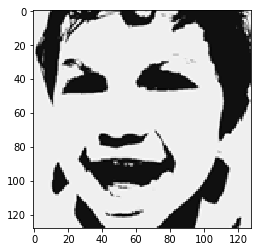

In [65]:
# content_img = np.array(sio.loadmat('test_sample.mat')['sample'],dtype='float32')
# content_img = content_img.reshape(1,128,128,1)
# plt.imshow(content_img.reshape(128,128),'gray')

# content_img = style_img.reshape(1,100,100,1)
plt.imshow(content_img.reshape(128,128),'gray')

In [2]:
# style_image = backend.variable(style_img)
# content_image = backend.variable(content_img)
# combination_image = backend.placeholder((1, height, width, 1))

style_image = tf.placeholder(tf.float32, shape=(1,100,100,1))
# content_image=tf.placeholder(tf.float32, shape=(1,128,128,1))
combination_image=tf.Variable(tf.random_uniform((1,100,100,1),0,1))


In [3]:
def conv2d(x, W, stride, padding="SAME"):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="VALID"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1],
                          strides=[1, stride, stride, 1], padding=padding)    

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
#     features = (features-features_mean)
    gram = backend.dot(features, backend.transpose(features))
#     D=tf.sqrt(tf.diag(tf.diag_part(gram)))
#     Q=tf.matmul(tf.matmul(tf.matrix_inverse(D),gram),tf.matrix_inverse(D))

#     return (gram-tf.reduce_min(tf.reshape(gram,[-1])))/(tf.reduce_max(tf.reshape(gram,[-1]))-tf.reduce_min(tf.reshape(gram,[-1]))) 
#     gram_dig = tf.diag_part(gram)   
    return gram
    
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 1
    size = height * width
    return backend.sum(backend.square(S - C))/ 1

In [4]:
import tensorflow as tf
W_conv1 = tf.reshape(tf.constant(W1),[12,12,1,64])
W_conv2 = tf.reshape(tf.constant(W2),[12,12,64,128])
# W_conv3 = tf.reshape(tf.constant(W3),[9,9,40,288])

b_conv1 = tf.reshape(tf.constant(bias1),[-1])
b_conv2 = tf.reshape(tf.constant(bias2),[-1])
# b_conv3 = tf.reshape(tf.constant(bias3),[-1])
############# white noise ############
combination_image = tf.nn.sigmoid(combination_image)
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.sigmoid(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=2, stride=2, padding="SAME")

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.sigmoid(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

# conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
# conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
# conv_out3 = tf.nn.relu(conv_out3)

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.sigmoid(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=2, stride=2, padding="SAME")

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.sigmoid(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

# conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
# conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
# conv_out3_S = tf.nn.relu(conv_out3_S)

############# content image ############
# conv_out1_C = conv2d(content_image, W_conv1, stride=1, padding='SAME')
# conv_out1_C = tf.nn.bias_add(conv_out1_C, b_conv1)
# conv_out1_C = tf.nn.sigmoid(conv_out1_C)
# conv_out1_C = max_pool(conv_out1_C, k_size=2, stride=2, padding="SAME")

# conv_out2_C = conv2d(conv_out1_C, W_conv2, stride=1, padding='SAME')
# conv_out2_C = tf.nn.bias_add(conv_out2_C, b_conv2)
# conv_out2_C = tf.nn.relu(conv_out2_C)
# conv_out2_C = max_pool(conv_out2_C, k_size=2, stride=2, padding="SAME")

# conv_out3_C = conv2d(conv_out2_C, W_conv3, stride=1, padding='SAME')
# conv_out3_C = tf.nn.bias_add(conv_out3_C, b_conv3)
# conv_out3_C = tf.nn.relu(conv_out3_C)

In [86]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

content_image_features = conv_out1_C
combination_features = conv_out1

cl = content_loss(content_image_features,combination_features)

In [5]:
# loss = backend.variable(0.)

sl1 = style_loss(conv_out1[0,:,:,:], conv_out1_S[0,:,:,:])
sl2 = style_loss(conv_out2[0,:,:,:], conv_out2_S[0,:,:,:])
# sl3 = style_loss(conv_out3[0,:,:,:], conv_out3_S[0,:,:,:])


gram_test1 =gram_matrix(conv_out1[0,:,:,:])
gram_test2 =gram_matrix(conv_out2[0,:,:,:])
# gram_test3 =gram_matrix(conv_out3[0,:,:,:])
gram_test1S=gram_matrix(conv_out1_S[0,:,:,:])
gram_test2S=gram_matrix(conv_out2_S[0,:,:,:])
# gram_test3S=gram_matrix(conv_out3_S[0,:,:,:])
loss = sl1 

# grads = backend.gradients(loss, combination_image)

# def total_variation_loss(x):
#     a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
#     b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
#     return backend.sum(backend.pow(a + b, 1.25))

# vl = total_variation_loss(combination_image)*10000

In [29]:
loss =sl1+sl2#+sl3*1

solver0 = tf.train.AdamOptimizer(learning_rate=1e-1).minimize(loss)
solver1 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss)
solver2 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
solver3 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

it=60000
for i in range(1000):
    _, loss0,loss1,loss2 = sess.run([solver0, loss,sl1,sl2], feed_dict={style_image: style_img})
#     _, loss1 = sess.run([solver0, loss], feed_dict={style_image: style_img})

#     solver.run()
    print('Iteration %d/%d' % (i + 1, it))

    if (i%5 == 0):
#         loss1 = loss.eval()
        print('    total loss0: %g' % loss0)
        print('    total loss1: %g' % loss1)
        print('    total loss2: %g' % loss2)

Iteration 1/60000
    total loss0: 2.22436e+08
    total loss1: 26484.6
    total loss2: 2.22409e+08
Iteration 2/60000
Iteration 3/60000
Iteration 4/60000
Iteration 5/60000
Iteration 6/60000
    total loss0: 1.35447e+08
    total loss1: 22359.2
    total loss2: 1.35425e+08
Iteration 7/60000
Iteration 8/60000
Iteration 9/60000
Iteration 10/60000
Iteration 11/60000
    total loss0: 4.59275e+07
    total loss1: 17927.7
    total loss2: 4.59095e+07
Iteration 12/60000
Iteration 13/60000
Iteration 14/60000
Iteration 15/60000
Iteration 16/60000
    total loss0: 5.95356e+06
    total loss1: 15148.2
    total loss2: 5.93842e+06
Iteration 17/60000
Iteration 18/60000
Iteration 19/60000
Iteration 20/60000
Iteration 21/60000
    total loss0: 1.73523e+06
    total loss1: 13277
    total loss2: 1.72195e+06
Iteration 22/60000
Iteration 23/60000
Iteration 24/60000
Iteration 25/60000
Iteration 26/60000
    total loss0: 1.63377e+06
    total loss1: 12121
    total loss2: 1.62165e+06
Iteration 27/60000
It

In [30]:
for i in range(10000):
    _, loss0,loss1,loss2 = sess.run([solver0, loss,sl1,sl2], feed_dict={style_image: style_img})
#     _, loss1 = sess.run([solver0, loss], feed_dict={style_image: style_img})

#     solver.run()
    print('Iteration %d/%d' % (i + 1, it))

    if (i%5 == 0):
#         loss1 = loss.eval()
        print('    total loss0: %g' % loss0)
        print('    total loss1: %g' % loss1)
        print('    total loss2: %g' % loss2)

Iteration 1/60000
    total loss0: 119013
    total loss1: 4878.98
    total loss2: 114134
Iteration 2/60000
Iteration 3/60000
Iteration 4/60000
Iteration 5/60000
Iteration 6/60000
    total loss0: 118497
    total loss1: 4867.89
    total loss2: 113629
Iteration 7/60000
Iteration 8/60000
Iteration 9/60000
Iteration 10/60000
Iteration 11/60000
    total loss0: 117984
    total loss1: 4856.94
    total loss2: 113128
Iteration 12/60000
Iteration 13/60000
Iteration 14/60000
Iteration 15/60000
Iteration 16/60000
    total loss0: 117476
    total loss1: 4846.11
    total loss2: 112630
Iteration 17/60000
Iteration 18/60000
Iteration 19/60000
Iteration 20/60000
Iteration 21/60000
    total loss0: 116971
    total loss1: 4835.42
    total loss2: 112135
Iteration 22/60000
Iteration 23/60000
Iteration 24/60000
Iteration 25/60000
Iteration 26/60000
    total loss0: 116469
    total loss1: 4824.85
    total loss2: 111644
Iteration 27/60000
Iteration 28/60000
Iteration 29/60000
Iteration 30/60000
I

(1, 100, 100, 1)


(array([ 2828.,   221.,   159.,   112.,   114.,   121.,   101.,   139.,
          298.,  5907.]),
 array([  1.63413584e-04,   1.00134496e-01,   2.00105578e-01,
          3.00076660e-01,   4.00047742e-01,   5.00018824e-01,
          5.99989906e-01,   6.99960988e-01,   7.99932070e-01,
          8.99903152e-01,   9.99874234e-01]),
 <a list of 10 Patch objects>)

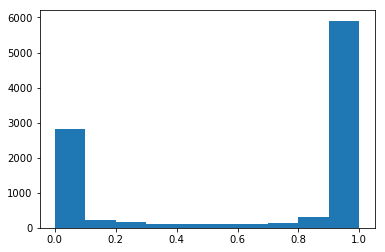

In [31]:
test1=sess.run(combination_image)
print test1.shape
plt.hist(test1.reshape(-1))

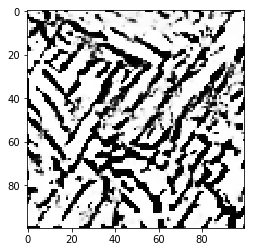

In [33]:
# import seaborn
plt.imshow(test1.reshape(100,100),'gray')
plt.grid(False)

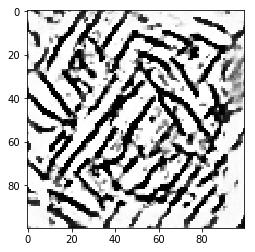

In [23]:
# import seaborn
plt.imshow(test1.reshape(100,100),'gray')
plt.grid(False)

(1, 50, 50, 64)


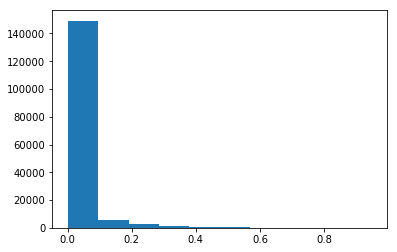

In [25]:
test1=sess.run(conv_out1_S, feed_dict={style_image: style_img})
plt.hist(test1.reshape(-1))
print test1.shape

(1, 50, 50, 64)


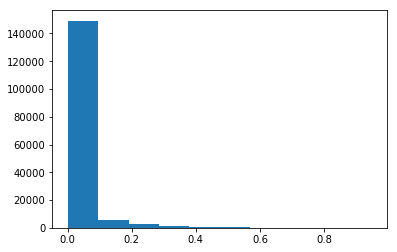

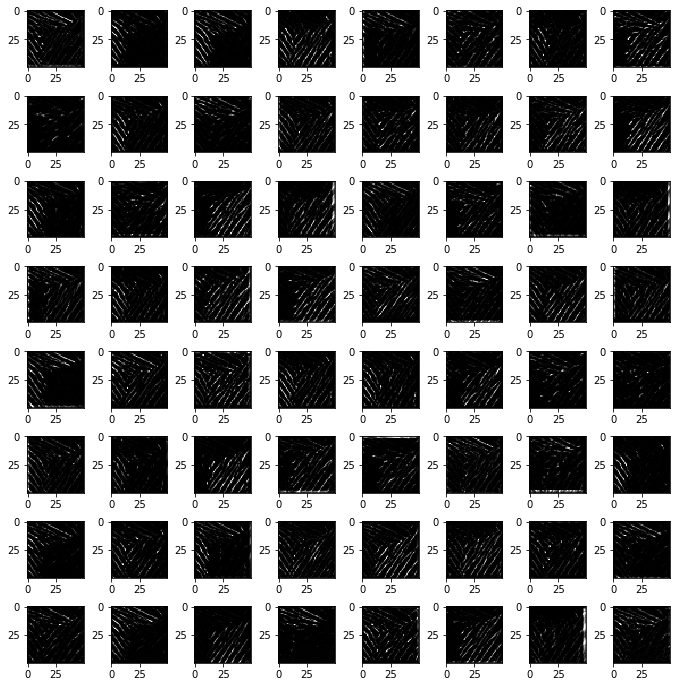

In [10]:
test1=sess.run(conv_out1_S, feed_dict={style_image: style_img})
plt.hist(test1.reshape(-1))
print test1.shape

fig, axs = plt.subplots(8,8, figsize=(12,12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(64):

    axs[i].imshow(test1[:,:,:,i].reshape(50,50),'gray')
    plt.grid(False)

(1, 50, 50, 64)


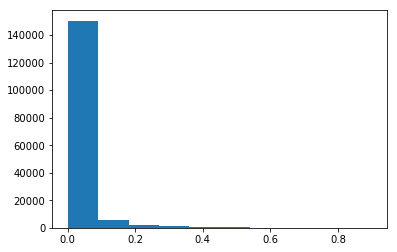

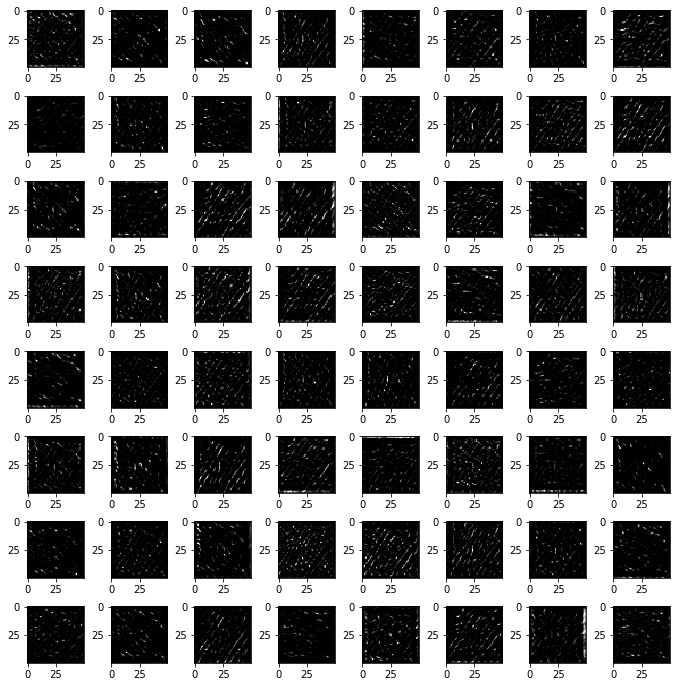

In [11]:
# sns.heatmap(test1.reshape(64*64,24))
# sns.heatmap(test1[:,:,:,0].reshape(50,50))
test2=sess.run(conv_out1, feed_dict={style_image: style_img})
plt.hist(test2.reshape(-1))
print test2.shape

fig, axs = plt.subplots(8,8, figsize=(12,12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(64):

    axs[i].imshow(test2[:,:,:,i].reshape(50,50),'gray')
    plt.grid(False)

In [63]:
test1=test1.reshape(50*50, 2)
np.dot(test1.T,test1)

array([[ 33.93787766,  28.43011856],
       [ 28.43011856,  28.71545601]], dtype=float32)

In [52]:
E1,E1S = sess.run([gram_test1, gram_test1S], feed_dict={style_image: style_img})
# import seaborn as sns
# sns.heatmap(E3S)

In [59]:
np.sum(np.square(E1-E1S))

1.9656469

In [14]:
test1=sess.run(conv_out2_S, feed_dict={style_image: style_img})
# plt.hist(test1.reshape(-1))
print test1.shape

(1, 25, 25, 128)


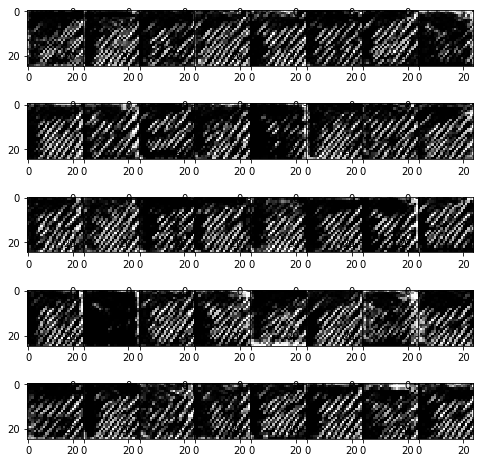

In [15]:
fig, axs = plt.subplots(5,8, figsize=(8, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(40):

    axs[i].imshow(test1[:,:,:,i].reshape(25,25),'gray')
    plt.grid(False)

(1, 25, 25, 288)


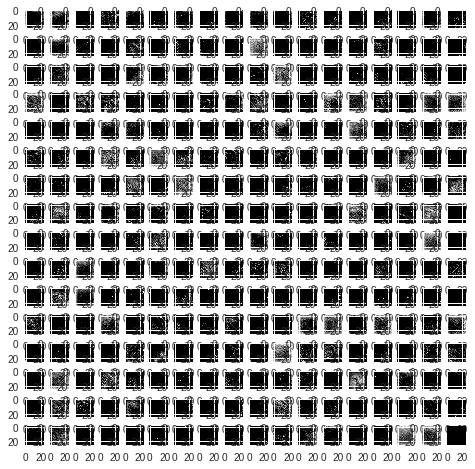

In [15]:
test1=sess.run(conv_out3_S, feed_dict={content_image: content_img,style_image: style_img})
# plt.hist(test1.reshape(-1))
print test1.shape

fig, axs = plt.subplots(16,18, figsize=(8, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(288):

    axs[i].imshow(test1[:,:,:,i].reshape(25,25),'gray')
    plt.grid(False)

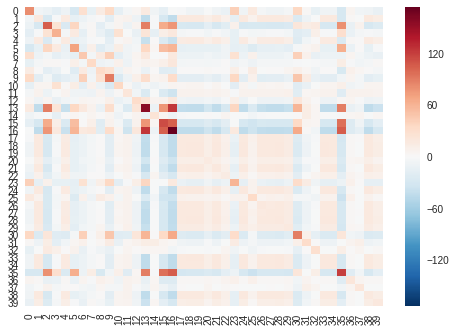

In [26]:
E1,E2,E3,E1S,E2S,E3S = sess.run([gram_test1,gram_test2,gram_test3, gram_test1S,gram_test2S,gram_test3S], feed_dict={content_image: content_img,
                                              style_image: style_img})
import seaborn as sns
sns.heatmap(E3S)

(1, 24, 24, 24)


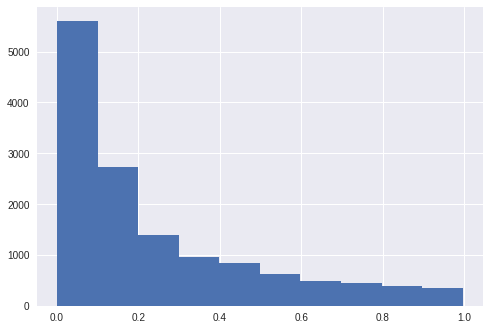

In [31]:
test2=sess.run(conv_out1, feed_dict={content_image: content_img,style_image: style_img})
plt.hist(test2.reshape(-1))
print test1.shape

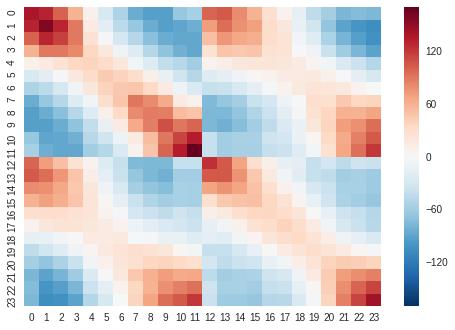

In [37]:
E1,E2,E3,E4 = sess.run([gram_test1,gram_test2,gram_test1S,gram_test2S], feed_dict={content_image: content_img,
                                              style_image: style_img})
import seaborn as sns
sns.heatmap(E3)

In [15]:
np.mean(np.square(E1-E3))

0.019924536

In [58]:
a = [[1, 0], [0, 1]]
b = [[4, 1], [2, 2]]
np.dot(a,b)

array([[4, 1],
       [2, 2]])

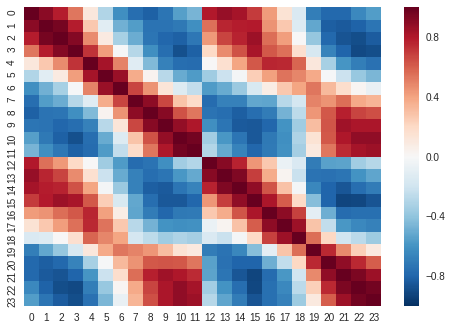

In [59]:
from numpy.linalg import inv
test1_mean=np.mean(test1.reshape(24*24,24),axis=1)
test1_mean=test1.reshape(24*24,24)-test1_mean.reshape(576,1)
test1_cov=np.dot(test1_mean.reshape(24*24,24).T,test1_mean.reshape(24*24,24))
test_diag=np.sqrt(np.diag(np.diag(test1_cov)))
test1_norm=np.matmul(np.matmul(inv(test_diag),test1_cov),inv(test_diag))
import seaborn as sns
sns.heatmap(test1_norm)
# print test1_norm

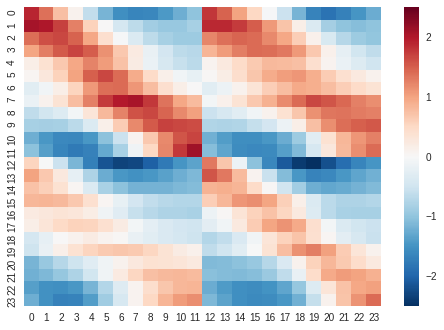

In [29]:
test1_cov=np.dot(test2.reshape(24*24,24).T,test2.reshape(24*24,24))
test1_norm=(test1_cov-np.mean(test1_cov,axis=0))/np.std(test1_cov,axis=0)
import seaborn as sns
sns.heatmap(test1_norm)
# print test1_norm

In [30]:
np.mean(np.square(test2-test1))

0.03815547

(24,)


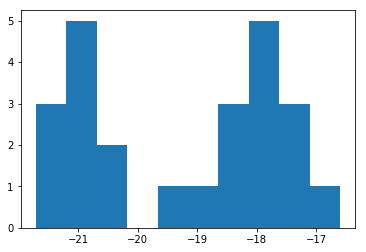

In [64]:
test1=sess.run(b_conv1)
plt.hist(test1.reshape(-1))
print test1.shape

(array([  4.60000000e+01,   6.52000000e+02,   5.57200000e+03,
          3.50000000e+04,   2.76410000e+04,   6.80400000e+03,
          1.54900000e+03,   3.85000000e+02,   1.01000000e+02,
          1.00000000e+01]),
 array([-2.17018247, -1.64833369, -1.12648492, -0.60463614, -0.08278737,
         0.4390614 ,  0.96091018,  1.48275895,  2.00460773,  2.5264565 ,
         3.04830527]),
 <a list of 10 Patch objects>)

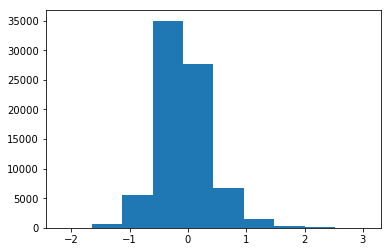

In [65]:
W2_test=sess.run(W_conv2, feed_dict={content_image: content_img,style_image: style_img})
plt.hist(W2_test.reshape(-1))

In [ ]:
test1

In [8]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 1))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [9]:
x = np.random.uniform(-1, 1, (1, height, width, 1))

iterations = 100

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

('Start of iteration', 0)
('Current loss value:', 161532.69)
Iteration 0 completed in 1s
('Start of iteration', 1)
('Current loss value:', 33240.461)
Iteration 1 completed in 0s
('Start of iteration', 2)
('Current loss value:', 12829.632)
Iteration 2 completed in 0s
('Start of iteration', 3)
('Current loss value:', 7217.2236)
Iteration 3 completed in 0s
('Start of iteration', 4)
('Current loss value:', 4870.9707)
Iteration 4 completed in 0s
('Start of iteration', 5)
('Current loss value:', 3543.3757)
Iteration 5 completed in 0s
('Start of iteration', 6)
('Current loss value:', 2712.8042)
Iteration 6 completed in 0s
('Start of iteration', 7)
('Current loss value:', 2181.7959)
Iteration 7 completed in 0s
('Start of iteration', 8)
('Current loss value:', 1745.8237)
Iteration 8 completed in 0s
('Start of iteration', 9)
('Current loss value:', 1437.484)
Iteration 9 completed in 0s
('Start of iteration', 10)
('Current loss value:', 1225.6289)
Iteration 10 completed in 0s
('Start of iteration

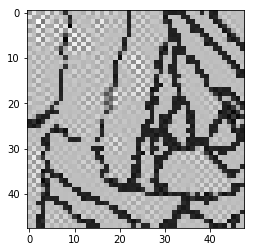

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
x = x.reshape((height, width, 1))
plt.imshow(x.reshape(48,48),'gray')